# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: user 79.1 ms, sys: 10.6 ms, total: 89.7 ms
Wall time: 89.2 ms


,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,...,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1,Recnum,Fraud
0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,1,0
1,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.0,...,1,1,31.42,1,1.0,1,1.0,1,2,0
2,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.0,...,1,1,178.49,1,1.0,1,1.0,1,3,0
3,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,4,0
4,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.5,...,1,1,7.24,1,0.5,1,1.0,1,5,0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_7',
 'Cardnum_count_1_by_30',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by60',
 'Card_dow_vdratio_0by14',
 'Merchnum_desc_State_total_3',
 'Card_Merchdesc_total_7',
 'Card_dow_unique_count_for_merch_zip_7',
 'Cardnum_actual/toal_0']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.0
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.0
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.5


In [5]:
vars.shape

(97496, 12)

In [6]:
vars['Fraud'].sum()

2047

In [7]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [8]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.000000
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.000000
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.000000
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.000000
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.500000
5,6,0,1,3.67,0.033333,3.67,0.000011,0.000049,3.67,3.67,1,1.000000
6,7,0,1,3.62,0.033333,3.62,0.000011,0.000049,7.24,3.62,1,1.000000
7,8,0,1,230.32,0.033333,230.32,0.000011,0.000049,230.32,230.32,1,1.000000
8,9,0,1,62.11,0.033333,62.11,0.000011,0.000049,62.11,62.11,1,1.000000
9,10,0,1,10.86,0.033333,3.62,0.016667,0.071429,10.86,10.86,1,0.333333


In [9]:
vars.shape

(97496, 12)

In [10]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,0.765940
std,28262.212670,0.143371,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,0.355093
min,1.000000,0.000000,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.000014
25%,24428.750000,0.000000,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,0.500000
50%,48916.000000,0.000000,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,1.000000
75%,73402.250000,0.000000,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1.000000
max,97852.000000,1.000000,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,1.000000


In [11]:
# find the row i vars that corresponds to 11/1 for the oot
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
84935,85265,0,1,174.61,0.016667,225.00,0.000074,0.000317,174.61,174.61,1,1.0
84936,85266,0,1,53.00,0.002778,395.00,0.000278,0.001190,53.00,53.00,1,1.0
84937,85267,0,1,25.00,0.004762,531.25,0.000417,0.002976,25.00,25.00,2,1.0
84938,85268,0,1,97.17,0.004762,395.04,0.000194,0.001661,97.17,97.17,1,1.0
84939,85269,0,1,6.51,0.016667,6.51,0.000167,0.001429,6.51,6.51,1,1.0
84940,85270,0,1,170.00,0.016667,170.00,0.000260,0.001116,170.00,170.00,1,1.0
84941,85271,0,1,250.00,0.002564,250.00,0.000149,0.001786,250.00,250.00,2,1.0
84942,85272,0,1,15.00,0.016667,103.60,0.000167,0.001429,15.00,15.00,1,1.0
84943,85273,0,1,300.00,0.006667,2105.00,0.000024,0.001984,300.00,300.00,1,1.0
84944,85274,0,1,133.20,0.002564,268.20,0.001042,0.004464,133.20,133.20,2,1.0


In [12]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [13]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,0.765940
std,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,0.355093
min,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.000014
25%,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,0.500000
50%,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,1.000000
75%,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1.000000
max,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,1.000000


In [14]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [15]:
# use this to cap variables. For some problems it helps
Clip = 10

In [16]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04
mean,1.049460e-17,-7.287917e-18,-5.830333e-19,7.870950e-18,-1.472159e-17,1.224370e-17,-1.166067e-18,-1.049460e-17,3.119228e-17,-4.372750e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.346282e-01,-1.044444e+00,-7.194261e-01,-6.452996e-01,-7.595529e-01,-4.318529e-01,-3.346955e-01,-5.031954e-01,-2.156969e+00
25%,-4.651796e-01,-3.065413e-01,-6.685133e-01,-5.318162e-01,-6.163864e-01,-7.020303e-01,-3.999404e-01,-3.066096e-01,-5.031954e-01,-7.489285e-01
50%,-4.651796e-01,-2.335016e-01,-3.902418e-01,-2.293881e-01,-5.725765e-01,-6.504263e-01,-3.179788e-01,-2.335723e-01,-5.031954e-01,6.591519e-01
75%,1.782986e-01,-1.893059e-02,2.733285e-01,3.461339e-01,3.065090e-01,8.313456e-01,-8.358364e-03,-1.900840e-02,6.696772e-02,6.591519e-01
max,1.009425e+01,2.183188e+01,2.927610e+00,1.136351e+01,2.689572e+00,1.892914e+00,1.638719e+01,2.183128e+01,1.069083e+01,6.591519e-01


In [17]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [18]:
len(X_trntst.columns)

10

In [19]:
X_trntst_save = X_trntst.copy()

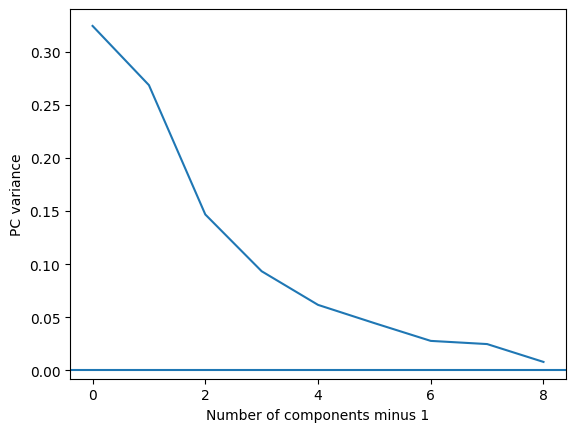

In [20]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [21]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.233799,-0.146768,-1.261853,2.670857
1,-1.217854,-0.125352,-1.258504,2.668163
2,-1.133501,-0.012059,-1.240786,2.653911
3,-1.233799,-0.146768,-1.261853,2.670857
4,1.747323,-2.263030,-3.108010,1.383728


In [22]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,0.474670,-0.992169,1.246312,-0.399651
85265,1.595099,-2.099471,-2.338872,1.408899
85266,-0.171959,1.949085,-0.161534,0.375554
85267,-1.073062,0.429463,0.660778,-0.213056
85268,-1.238510,0.678886,-0.019114,-0.217072


In [23]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.002794,-0.013411,0.003866,0.000122,0.003494,0.011369,0.002805,0.004227,-0.007076
std,1.007299,1.029148,0.996083,0.988241,0.999618,1.000623,1.038863,1.029151,1.014974,1.003383
min,-0.465180,-0.334628,-1.044444,-0.719426,-0.645300,-0.759504,-0.431853,-0.334696,-0.503195,-2.156969
25%,-0.465180,-0.307403,-0.680554,-0.528478,-0.616386,-0.699287,-0.400153,-0.307467,-0.503195,-0.748928
50%,-0.465180,-0.234920,-0.390242,-0.220376,-0.572577,-0.640374,-0.318782,-0.234966,-0.503195,0.659152
75%,0.178299,-0.019391,0.273329,0.354082,0.306509,0.831346,-0.004259,-0.019273,0.066968,0.659152
max,10.094246,21.831881,2.927610,11.363510,2.689572,1.892914,16.387194,21.831284,10.690830,0.659152


In [24]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.084839,-0.037318,-0.060807,0.090004
std,1.689561,1.360119,1.158176,0.966594
min,-1.696425,-6.345955,-4.842932,-4.632864
25%,-1.295068,-0.697445,-0.557728,-0.438803
50%,-0.893845,0.194860,-0.029108,-0.109650
75%,1.045609,0.502024,0.389831,0.438306
max,21.527572,29.137615,9.748135,5.452739


In [25]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [26]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,8.526400e+04
mean,1.000013e-17,-7.333430e-18,-9.000119e-18,2.000026e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.533328e-01,-4.052689e+00,-5.196134e+00,-4.686439e+00
25%,-6.921927e-01,-4.952199e-01,-4.252566e-01,-5.479011e-01
50%,-4.120381e-01,1.169866e-01,1.252057e-02,-1.881926e-01
75%,5.904588e-01,3.207532e-01,3.698016e-01,3.265700e-01
max,1.341726e+01,1.839694e+01,1.136849e+01,6.388562e+00


In [27]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.046605,-0.022527,-0.049643,0.092140
std,0.928131,0.821052,0.945546,0.989529
min,-0.931901,-3.830809,-3.953814,-4.742789
25%,-0.711423,-0.421021,-0.455334,-0.449215
50%,-0.491018,0.117629,-0.023764,-0.112251
75%,0.574387,0.303053,0.318262,0.448706
max,11.825793,17.589258,7.958466,5.582118


In [28]:
X_trntst_pca.shape

(85264, 4)

In [29]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [30]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 10) 3464


In [31]:
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [32]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [33]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.683104284559418 0.6744639376218323 0.4612794612794613
1 0.6851239669421487 0.6759259259259259 0.468013468013468
2 0.6731707317073171 0.7019230769230769 0.46464646464646464
3 0.6849876948318294 0.6741996233521658 0.4612794612794613
4 0.6826446280991736 0.687037037037037 0.46464646464646464
5 0.6647864625302176 0.7190569744597249 0.47474747474747475
6 0.6779801324503312 0.6863468634686347 0.46464646464646464
7 0.6707416462917686 0.6959847036328872 0.46464646464646464
8 0.6883223684210527 0.6704119850187266 0.4612794612794613
9 0.6792908944399678 0.6856581532416502 0.4713804713804714
trn    0.679015
tst    0.687101
oot    0.465657
dtype: float64
CPU times: user 11.6 s, sys: 780 ms, total: 12.4 s
Wall time: 1.75 s


In [34]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 1.0 0.6691449814126395 0.37037037037037035
1 1.0 0.6533333333333333 0.3569023569023569
2 1.0 0.663003663003663 0.3872053872053872
3 1.0 0.6673003802281369 0.4006734006734007
4 1.0 0.6536203522504892 0.3838383838383838
5 1.0 0.6826923076923077 0.3569023569023569
6 1.0 0.651685393258427 0.367003367003367
7 1.0 0.675 0.3400673400673401
8 1.0 0.6622889305816135 0.4074074074074074
9 1.0 0.6398390342052314 0.367003367003367
trn    1.000000
tst    0.661791
oot    0.373737
dtype: float64
CPU times: user 5.75 s, sys: 1.1 s, total: 6.85 s
Wall time: 5.29 s


In [35]:
# %%time
# # RF

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# # Note for students: The default values are a fairly complex architecture and make this cell run slow.
#     model = RandomForestClassifier()
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [36]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.9883236030025021 0.8130671506352087 0.4983164983164983
1 0.9852579852579852 0.8128544423440454 0.5016835016835017
2 0.9818037974683544 0.8127572016460906 0.5757575757575758
3 0.9840510366826156 0.8467741935483871 0.5185185185185185
4 0.9845276872964169 0.7873563218390804 0.4781144781144781
5 0.9797242497972425 0.804642166344294 0.5286195286195287
6 0.9858803986710963 0.8021978021978022 0.569023569023569
7 0.9840336134453781 0.8142857142857143 0.48148148148148145
8 0.9855072463768116 0.804159445407279 0.5151515151515151
9 0.9829129373474369 0.8464491362763915 0.4882154882154882
trn    0.984202
tst    0.814454
oot    0.515488
dtype: float64
CPU times: user 9.96 s, sys: 3.98 s, total: 13.9 s
Wall time: 4.67 s


In [37]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [38]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [39]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
# Note for students: The default values are a fairly complex architecture and make this cell run slow.
    model = MLPClassifier(hidden_layer_sizes=(1,1))
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.03559602649006623 0.025830258302583026 0.06397306397306397
1 0.03042433947157726 0.01996007984031936 0.06397306397306397
2 0.681592039800995 0.6801470588235294 0.4612794612794613
3 0.02834008097165992 0.038834951456310676 0.06397306397306397
4 0.6878088962108732 0.6884328358208955 0.4781144781144781
5 0.6871508379888268 0.6800804828973843 0.4781144781144781
6 0.6998341625207297 0.6672794117647058 0.4882154882154882
7 0.03377265238879736 0.026119402985074626 0.06397306397306397
8 0.6843853820598007 0.6886446886446886 0.48148148148148145
9 0.03827751196172249 0.036290322580645164 0.06397306397306397
trn    0.360718
tst    0.355162
oot    0.270707
dtype: float64
CPU times: user 24.3 s, sys: 4.81 s, total: 29.1 s
Wall time: 13.1 s


In [40]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(10,10),alpha=.005,solver='adam',activation='relu',
#                           max_iter=1000,learning_rate='adaptive',learning_rate_init=.01)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [41]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(learning_rate=0.01,max_depth=4,n_estimators=300)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [42]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.9408381265406738 0.8067542213883677 0.5353535353535354
1 0.9391727493917275 0.839458413926499 0.5488215488215489
2 0.9382022471910112 0.8253968253968254 0.5252525252525253
3 0.9350862777321282 0.8405253283302064 0.5488215488215489
4 0.9288052373158756 0.8503787878787878 0.5286195286195287
5 0.9316872427983539 0.8186915887850468 0.5521885521885522
6 0.9363929146537843 0.8267716535433071 0.5353535353535354
7 0.9354838709677419 0.8333333333333334 0.5387205387205387
8 0.9368505195843325 0.8376753507014028 0.5488215488215489
9 0.9415584415584416 0.805019305019305 0.5488215488215489
trn    0.936408
tst    0.828400
oot    0.541077
dtype: float64
CPU times: user 2min 31s, sys: 43.7 s, total: 3min 15s
Wall time: 49.3 s


In [43]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = lgb.LGBMClassifier(num_leaves=4,n_estimators=30)

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [44]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=100)
# #             learning_rate=detect_rate,
# #             l2_leaf_reg=5  
# #

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [45]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # XGB

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# #     model = xgb.XGBClassifier(booster='gbtree',max_depth=4,min_child_weight=75,gamma=0.01)
#     model = xgb.XGBClassifier(booster='gbtree',n_estimators=70,max_depth=3,learning_rate=.1)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [47]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
#     model = KNeighborsClassifier(n_neighbors=80) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [48]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [49]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.683104,0.674464,0.461279
1,log reg,0.685124,0.675926,0.468013
2,log reg,0.673171,0.701923,0.464646
3,log reg,0.684988,0.6742,0.461279
4,log reg,0.682645,0.687037,0.464646
5,log reg,0.664786,0.719057,0.474747
6,log reg,0.67798,0.686347,0.464646
7,log reg,0.670742,0.695985,0.464646
8,log reg,0.688322,0.670412,0.461279
9,log reg,0.679291,0.685658,0.47138


In [50]:
df.shape

(50, 4)

In [51]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.683104
1,log reg,Trn,0.685124
2,log reg,Trn,0.673171
3,log reg,Trn,0.684988
4,log reg,Trn,0.682645


In [52]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.683104
1,log reg,Trn,0.685124
2,log reg,Trn,0.673171
3,log reg,Trn,0.684988
4,log reg,Trn,0.682645


In [53]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT              1.0  0.000000  0.661791  0.012560  0.373737  0.020937
LGBM       0.984202  0.002363  0.814454  0.018745  0.515488  0.034096
NN         0.360718  0.345189  0.355162  0.343465  0.270707  0.218017
cat boost  0.936408  0.003943    0.8284  0.014847  0.541077  0.009661
log reg    0.679015  0.007422  0.687101  0.015100  0.465657  0.004503

In [54]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.683104,0.674464,0.461279
1,log reg,0.685124,0.675926,0.468013
2,log reg,0.673171,0.701923,0.464646
3,log reg,0.684988,0.6742,0.461279
4,log reg,0.682645,0.687037,0.464646


In [55]:
best_OOT = df['OOT'].max()
best_OOT

0.5757575757575758

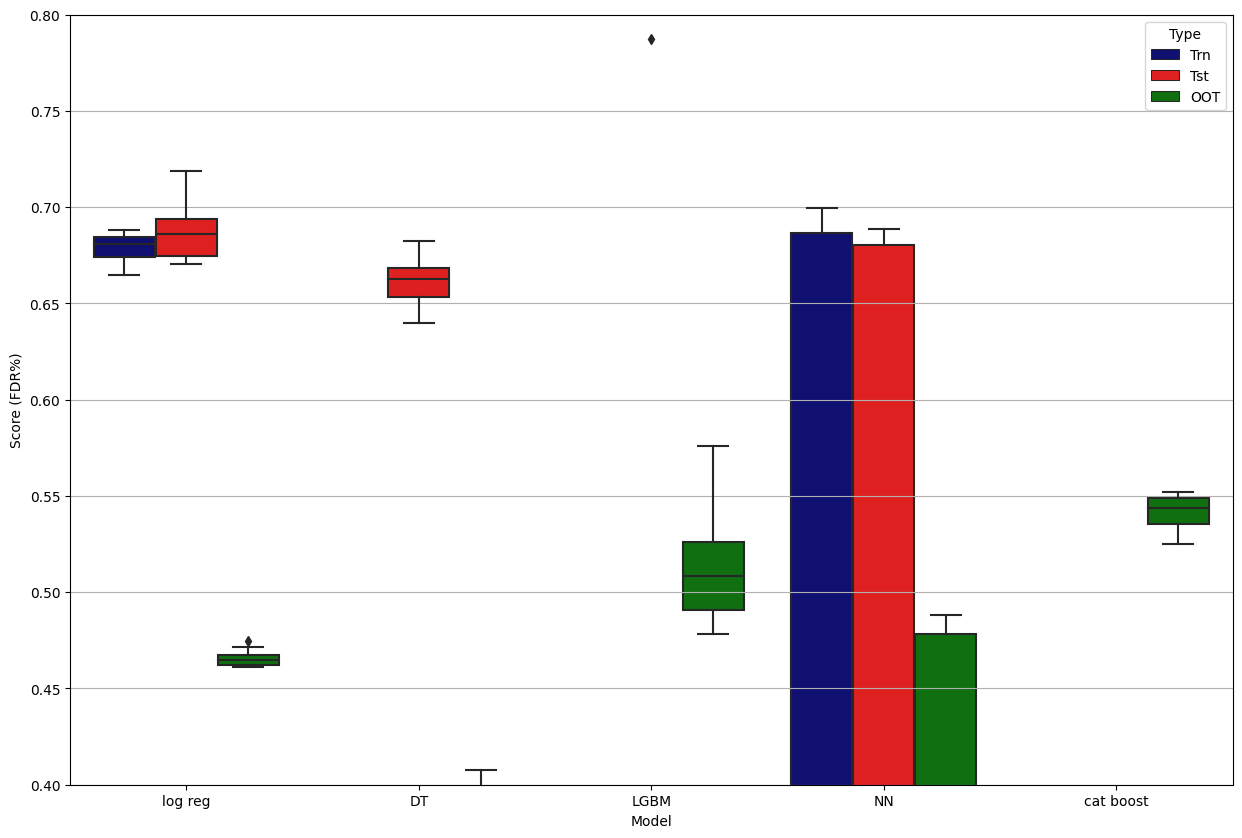

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,.8)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [57]:
print('duration: ', datetime.now() - start_time)

duration:  0:01:16.200336


This next cell can be used to explore overfitting

In [58]:
# %%time
# nitermax2 = 3
# training = []
# testing = []
# oot = []
# results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
# for i in range():
#     for niter in range(nitermax2):
#         X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
#         model = lgb.LGBMClassifier()

#         model.fit(X_trn, Y_trn.values.ravel()) 

#         X_oot = X_oot_orig.copy()
#         X_trn_save = X_trn.copy()
#         Y_trn_save = Y_trn.copy()
    
#         predictions = model.predict_proba(X_trn_save)[:,1]
#         X_trn['predicted'] = predictions
#         X_trn['Fraud'] = Y_trn_save['Fraud']
#         topRows = int(round(X_trn.shape[0]*detect_rate))
#         temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#         needed = temp.loc[:,'Fraud']
#         results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#         predictions = model.predict_proba(X_tst)[:,1]
#         X_tst['predicted']=predictions
#         X_tst['Fraud'] = Y_tst['Fraud']
#         topRows = int(round(X_tst.shape[0]*detect_rate))
#         temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#         needed = temp.loc[:,'Fraud']
#         results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#         predictions = model.predict_proba(X_oot)[:,1]
#         X_oot['predicted']=predictions
#         X_oot['Fraud'] = Y_oot['Fraud']
#         topRows = int(round(X_oot.shape[0]*detect_rate))
#         temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#         needed = temp.loc[:,'Fraud']
#         results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#         print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

#     results_mean_trn = results['trn'].mean()
#     results_mean_tst = results['tst'].mean()
#     results_mean_oot = results['oot'].mean()
#     print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
#     training.append(results_mean_trn)
#     testing.append(results_mean_tst)
#     oot.append(results_mean_oot)

# table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True) 
# table.plot()
# plt.savefig('complexity_NN.pdf', format='pdf')
# plt.show()

In [59]:
best_OOT

0.5757575757575758

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [60]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nombermof times with your fixed hyperparameters until it finds a good model.
desire = .52
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice

    model = lgb.LGBMClassifier()
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.52
0 0.9792166266986411 0.8236472945891784 0.5656565656565656
CPU times: user 982 ms, sys: 388 ms, total: 1.37 s
Wall time: 479 ms


In [61]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [62]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,predicted,Fraud
90973,7.256559,-0.328159,2.264040,-0.185289,2.522758,1.892914,-0.427990,-0.328227,8.619415,-2.149524,0.988219,1
96274,8.543516,-0.328785,2.384689,-0.188352,2.689572,1.892914,-0.428364,-0.328853,6.338762,-2.147548,0.985197,1
94031,7.900037,-0.324574,1.047494,-0.114619,1.512059,1.671754,-0.425850,-0.324642,5.198436,-2.142262,0.984088,1
96243,7.900037,-0.322862,2.330397,-0.188352,2.689572,1.892914,-0.424828,-0.322929,5.198436,-2.137171,0.981950,1
93991,7.256559,-0.327062,0.993776,-0.114619,1.438464,1.651648,-0.074768,-0.327130,4.628273,-2.145851,0.979224,1
90122,-0.465180,12.941243,2.780150,1.493632,2.689572,1.892914,7.494529,12.940735,-0.503195,-1.979310,0.979099,1
90111,-0.465180,11.622760,2.761717,1.493632,2.689572,1.892914,6.707327,11.622297,-0.503195,-1.922514,0.979099,1
90114,-0.465180,11.812546,2.768353,1.493632,2.689572,1.892914,6.820639,11.812076,-0.503195,-1.969291,0.979099,1
88705,3.395690,-0.138769,1.221286,-0.495720,1.577476,1.892914,-0.292395,-0.138843,0.066968,-0.523420,0.977822,0
94098,6.613081,-0.324328,0.439221,-0.114619,2.022315,1.892914,-0.425703,-0.324395,1.207294,-2.104184,0.977440,0


In [63]:
cost_fraud = 1000
cost_fp = 30
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,30.0,92.0,24.590164,75.409836,122.0,30.0,92.0,0.251362,30.976431,30.725069,0.326087
2,2.0,123.0,77.0,46.0,62.601626,37.398374,245.0,107.0,138.0,0.896523,46.464646,45.568124,0.775362
3,3.0,122.0,92.0,30.0,75.409836,24.590164,367.0,199.0,168.0,1.667365,56.565657,54.898292,1.184524
4,4.0,122.0,104.0,18.0,85.245902,14.754098,489.0,303.0,186.0,2.538752,62.626263,60.087511,1.629032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,123.0,0.0,100.000000,0.000000,11743.0,11446.0,297.0,95.902807,100.000000,4.097193,38.538721
97,97.0,122.0,122.0,0.0,100.000000,0.000000,11865.0,11568.0,297.0,96.925010,100.000000,3.074990,38.949495
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11690.0,297.0,97.947214,100.000000,2.052786,39.360269
99,99.0,123.0,123.0,0.0,100.000000,0.000000,12110.0,11813.0,297.0,98.977796,100.000000,1.022204,39.774411


Max possible savings: 46,812,000.0


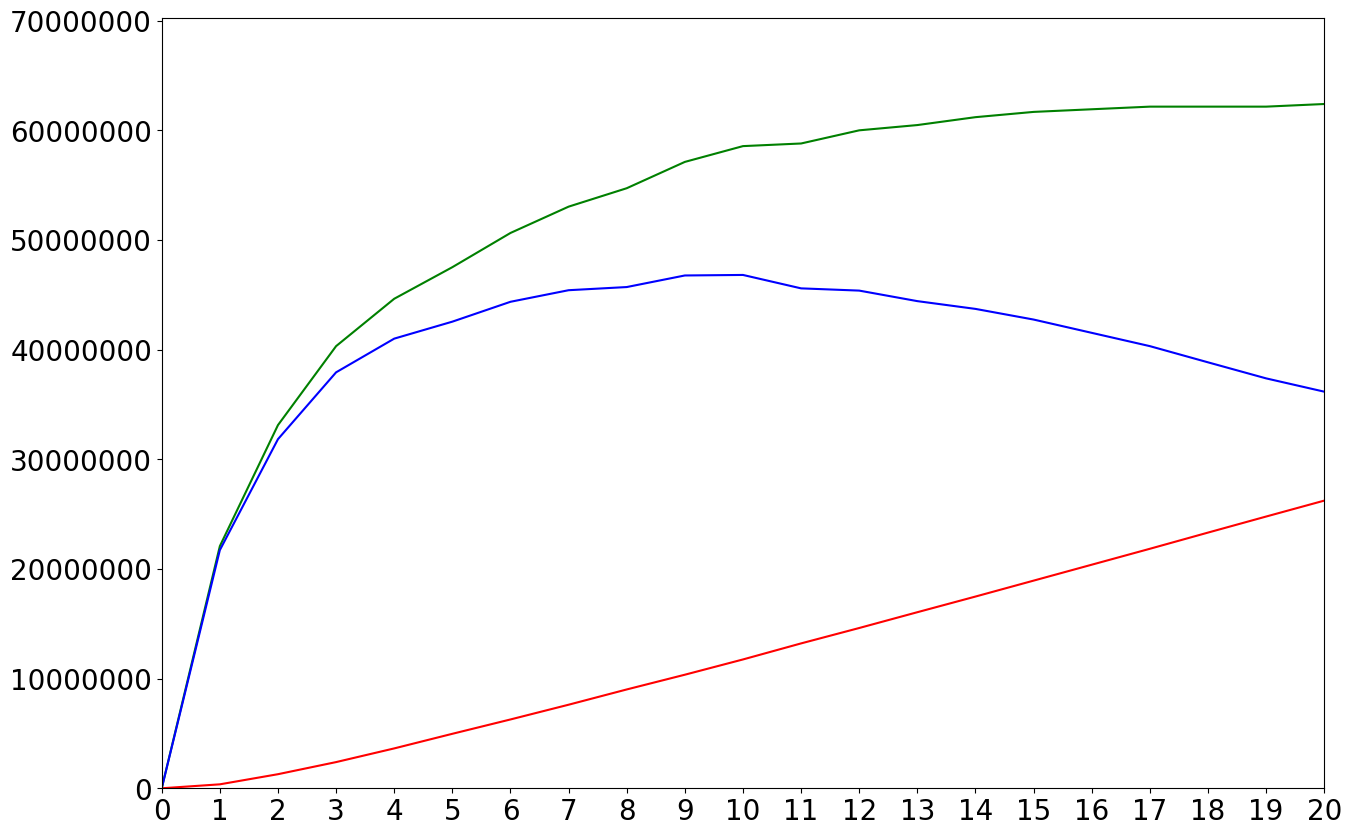

In [64]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [65]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,30.0,92.0,24.590164,75.409836,122.0,30.0,92.0,0.251362,30.976431,30.725069,0.326087
2,2.0,123.0,77.0,46.0,62.601626,37.398374,245.0,107.0,138.0,0.896523,46.464646,45.568124,0.775362
3,3.0,122.0,92.0,30.0,75.409836,24.590164,367.0,199.0,168.0,1.667365,56.565657,54.898292,1.184524
4,4.0,122.0,104.0,18.0,85.245902,14.754098,489.0,303.0,186.0,2.538752,62.626263,60.087511,1.629032
5,5.0,123.0,111.0,12.0,90.243902,9.756098,612.0,414.0,198.0,3.468789,66.666667,63.197877,2.090909
6,6.0,122.0,109.0,13.0,89.344262,10.655738,734.0,523.0,211.0,4.382070,71.043771,66.661702,2.478673
7,7.0,122.0,112.0,10.0,91.803279,8.196721,856.0,635.0,221.0,5.320486,74.410774,69.090288,2.873303
8,8.0,123.0,116.0,7.0,94.308943,5.691057,979.0,751.0,228.0,6.292417,76.767677,70.475260,3.293860
9,9.0,122.0,112.0,10.0,91.803279,8.196721,1101.0,863.0,238.0,7.230834,80.134680,72.903846,3.626050


In [66]:
FDR.to_csv('FDR.csv')

In [67]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [68]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

11935.0 297.0 12232.0 12232.0


In [69]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

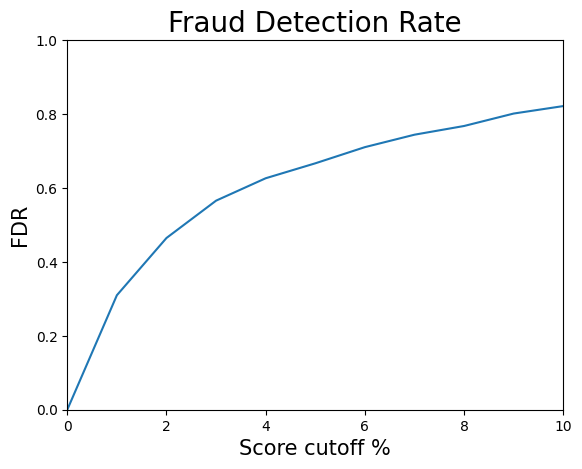

In [70]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

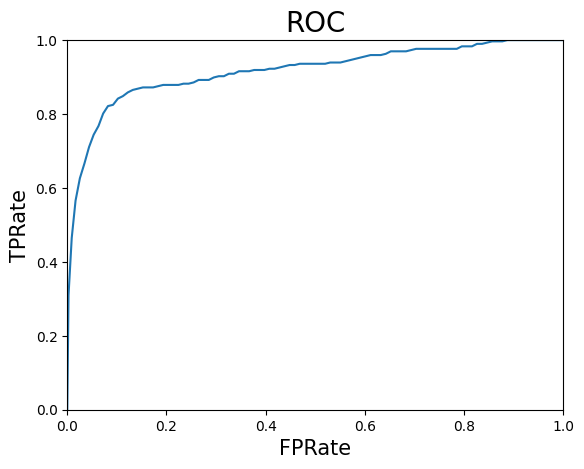

In [71]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [72]:
print("duration: ", datetime.now() - start_time)

duration:  0:01:17.507245


In [73]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/UCSD/2024 Spring Fraud/Classes'

In [74]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 251 ms, sys: 11.2 ms, total: 262 ms
Wall time: 90.4 ms


<timed exec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(97496, 10)

In [75]:
df['prediction'] = model.predict_proba(X)[:,1]

In [76]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [77]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000712
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.000218
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.016573
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000712
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000264


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           94276 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        96468 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  prediction         97496 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.9+ MB


In [79]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
63708,63709,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,891.97,1,1.000000
63520,63521,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,809.83,1,0.996498
63919,63920,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,860.35,1,0.996184
63899,63900,5142249750,2010-08-14,92891948003,ONLINE SERVICES INC,TX,75230.0,P,871.70,1,0.996184
63530,63531,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,726.74,1,0.995729
63535,63536,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,717.17,1,0.995729
63552,63553,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,728.95,1,0.995729
36201,36202,5142271065,2010-05-15,4620009957157,DSI TERMITE & PEST CON,MD,20607.0,P,2612.16,1,0.995076
50903,50904,5142176939,2010-07-05,4503082476300,OFFICE DEPOT #1082,MD,20763.0,P,1365.00,1,0.994794
67022,67023,5142140316,2010-08-23,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,1591.85,1,0.994157


In [80]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142189341    41
5142160778    41
5142225942    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
5142226204    35
5142260253    34
5142189108    33
Name: count, dtype: int64

In [81]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     151
4353000719908    116
9108234610000     48
8834000695423     46
4503738417400     45
9900020006406     43
4620009957157     41
4503082476300     39
618901687330      36
900009045549      36
253052983001      34
938909877224      32
6006333528866     30
997674930332      30
6070095870009     27
Name: count, dtype: int64

In [82]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
# sample = df[df['Cardnum'] == card]
sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

116

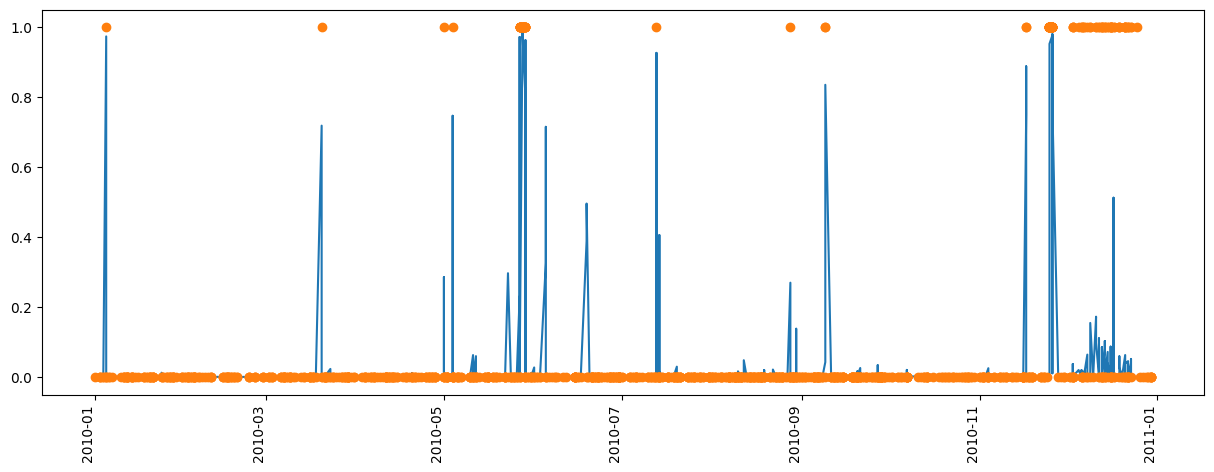

In [83]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [84]:
tsample = sample[sample['Date'] > '2010-11-09']
tsample = tsample[tsample['Date'] < '2010-12-01']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,87351,87352,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.000668
1,2,87370,87371,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001466
2,3,87449,87450,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.001331
3,4,87766,87767,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000101
4,5,87871,87872,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.001830


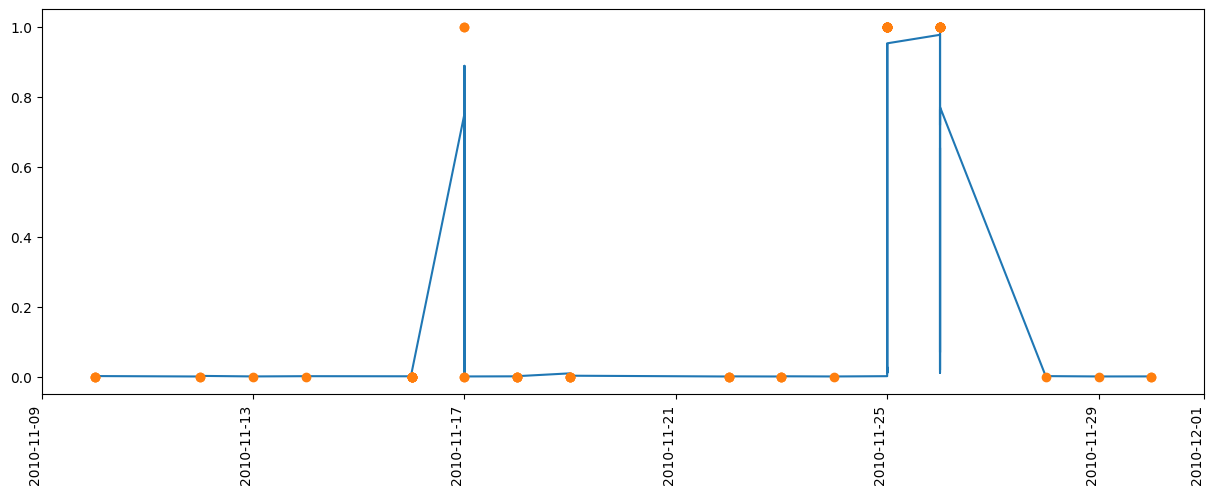

In [85]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])

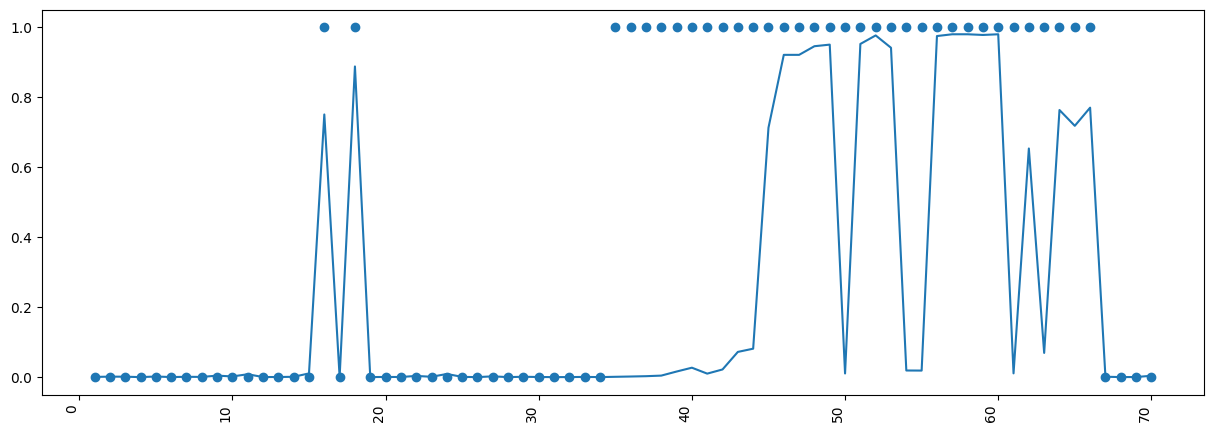

In [86]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])

In [87]:
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,87351,87352,5142180432,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,237.60,0,0.000668
1,2,87370,87371,5142139483,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,178.36,0,0.001466
2,3,87449,87450,5142178848,2010-11-10,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,15.11,0,0.001331
3,4,87766,87767,5142146217,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,63.45,0,0.000101
4,5,87871,87872,5142223659,2010-11-12,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,73.90,0,0.001830
5,6,87948,87949,5142137416,2010-11-13,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.90,0,0.000268
6,7,87964,87965,5142236799,2010-11-14,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,98.60,0,0.000986
7,8,88251,88252,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,32.28,0,0.000675
8,9,88287,88288,5142226979,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,35.06,0,0.004323
9,10,88393,88394,5142221962,2010-11-16,4353000719908,ACI*AMAZON.COM INC,WA,98101.0,P,234.54,0,0.002038


# Score Calibration

In [88]:
base = 700
delta = 40
odds_at_base = 1

In [89]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(97496, 12)

In [90]:
df.head()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,predicted,Fraud
35197,0.821777,0.873428,-0.485038,0.660802,0.306509,1.008274,0.367953,0.873320,0.066968,0.522217,0.003128,0
58988,0.821777,-0.307221,-0.441286,0.260552,0.094681,0.300562,-0.398832,-0.307289,0.637131,-1.998142,0.001490,0
68990,-0.465180,0.967079,-0.819611,0.767807,-0.577210,-0.694658,0.487900,0.966969,1.777457,0.659152,0.001231,0
76294,-0.465180,-0.299788,-0.556134,-0.333691,-0.507704,-0.595136,-0.411052,-0.299857,0.066968,0.659152,0.000752,0
13171,-0.465180,-0.187484,-0.722027,0.187534,-0.594587,-0.650426,-0.344000,-0.187556,0.637131,0.659152,0.001398,0


In [91]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

,score_raw,Fraud
79750,0.000015,0
73250,0.000016,0
28413,0.000016,0
54964,0.000017,0
61983,0.000017,0


In [92]:
calib.shape

(97496, 2)

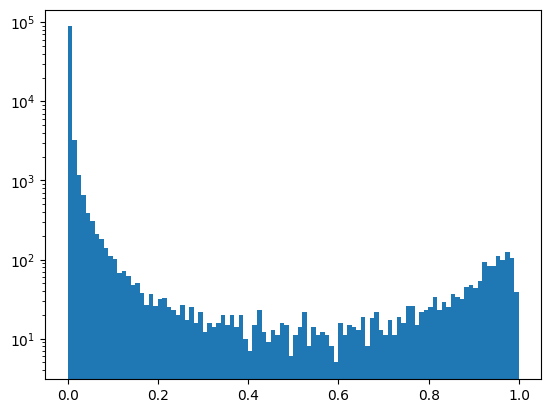

In [93]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [94]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [95]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2047 95449


In [96]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000034,0.000000,0.000001,-13.790193,-8.000000
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000048,0.000000,0.000001,-13.790193,-8.000000
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000059,0.000000,0.000001,-13.790193,-8.000000
4,4.0,975.0,974.0,1.0,99.897436,0.102564,3900.0,3899.0,1.0,0.000069,0.102564,0.001028,-6.880412,-6.880412
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4874.0,1.0,0.000079,0.000000,0.000001,-13.790193,-6.880412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,975.0,942.0,33.0,96.615385,3.384615,93600.0,93398.0,198.0,0.034024,3.384615,0.035033,-3.351467,-3.351467
97,97.0,975.0,921.0,54.0,94.461538,5.538462,94575.0,94319.0,252.0,0.057778,5.538462,0.058633,-2.836457,-2.836457
98,98.0,975.0,818.0,157.0,83.897436,16.102564,95550.0,95137.0,409.0,0.144819,16.102564,0.191933,-1.650610,-1.650610
99,99.0,975.0,275.0,700.0,28.205128,71.794872,96525.0,95412.0,1109.0,0.602269,71.794872,2.545458,0.934311,0.934311


In [97]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,975.0,942.0,33.0,96.615385,3.384615,93600.0,93398.0,198.0,0.034024,3.384615,0.035033,-3.351467,-3.351467
97,97.0,975.0,921.0,54.0,94.461538,5.538462,94575.0,94319.0,252.0,0.057778,5.538462,0.058633,-2.836457,-2.836457
98,98.0,975.0,818.0,157.0,83.897436,16.102564,95550.0,95137.0,409.0,0.144819,16.102564,0.191933,-1.650610,-1.650610
99,99.0,975.0,275.0,700.0,28.205128,71.794872,96525.0,95412.0,1109.0,0.602269,71.794872,2.545458,0.934311,0.934311
100,100.0,975.0,37.0,938.0,3.794872,96.205128,97500.0,95449.0,2047.0,0.942640,96.205128,25.351378,3.232833,3.232833


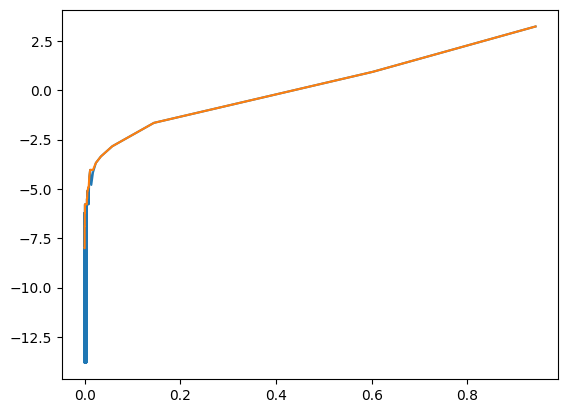

In [98]:
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [99]:
def func(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcinv(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [100]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.94188106  0.94013796 -0.00245399]


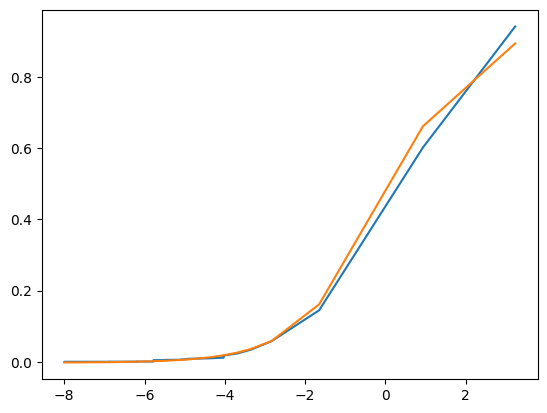

In [101]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],func(cal_bins['log_odds_adj'], *popt))

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


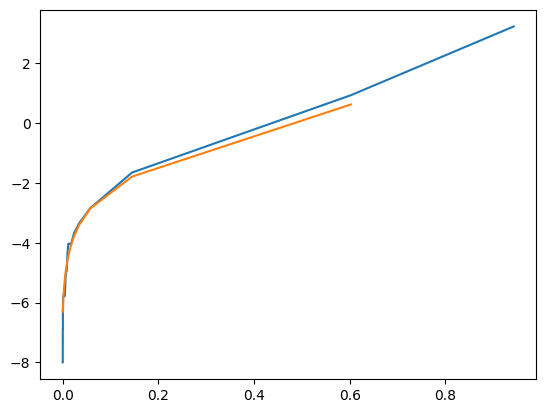

In [102]:
# look at the smooth curve fit to see if it's OK.
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcinv(cal_bins['score_raw'], *popt))

In [103]:
# The fit looks pretty good
cal_bins['fit'] = funcinv(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000034,0.000000,0.000001,-13.790193,-8.000000,-6.297980
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000048,0.000000,0.000001,-13.790193,-8.000000,-6.292011
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000059,0.000000,0.000001,-13.790193,-8.000000,-6.287371
4,4.0,975.0,974.0,1.0,99.897436,0.102564,3900.0,3899.0,1.0,0.000069,0.102564,0.001028,-6.880412,-6.880412,-6.283008
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4874.0,1.0,0.000079,0.000000,0.000001,-13.790193,-6.880412,-6.278863
6,6.0,975.0,975.0,0.0,100.000000,0.000000,5850.0,5849.0,1.0,0.000090,0.000000,0.000001,-13.790193,-6.880412,-6.274367
7,7.0,975.0,975.0,0.0,100.000000,0.000000,6825.0,6824.0,1.0,0.000101,0.000000,0.000001,-13.790193,-6.880412,-6.269490
8,8.0,975.0,974.0,1.0,99.897436,0.102564,7800.0,7798.0,2.0,0.000114,0.102564,0.001028,-6.880412,-6.880412,-6.264174
9,9.0,975.0,975.0,0.0,100.000000,0.000000,8775.0,8773.0,2.0,0.000127,0.000000,0.000001,-13.790193,-6.880412,-6.258853
10,10.0,975.0,975.0,0.0,100.000000,0.000000,9750.0,9748.0,2.0,0.000140,0.000000,0.000001,-13.790193,-6.880412,-6.253712


In [104]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [105]:
calib.head()

,score_raw,Fraud
79750,0.000015,0
73250,0.000016,0
28413,0.000016,0
54964,0.000017,0
61983,0.000017,0


In [106]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcinv(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,score_raw,Fraud,score_calib
79750,0.000015,0,447.752999
73250,0.000016,0,447.770557
28413,0.000016,0,447.773032
54964,0.000017,0,447.787687
61983,0.000017,0,447.791153


In [107]:
calib.tail()

,score_raw,Fraud,score_calib
63316,0.995152,1,999.0
63699,0.995607,1,999.0
63679,0.995607,1,999.0
63301,0.995921,1,999.0
63489,0.999000,1,999.0


In [108]:
calib.describe()

,score_raw,Fraud,score_calib
count,97496.000000,97496.000000,97496.000000
mean,0.019922,0.020996,479.378238
std,0.113032,0.143371,61.498662
min,0.000015,0.000000,447.752999
25%,0.000406,0.000000,454.017195
50%,0.001052,0.000000,462.699916
75%,0.002680,0.000000,478.964872
max,0.999000,1.000000,999.000000


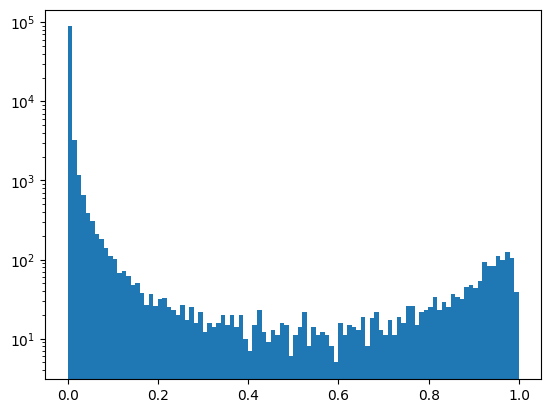

In [109]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

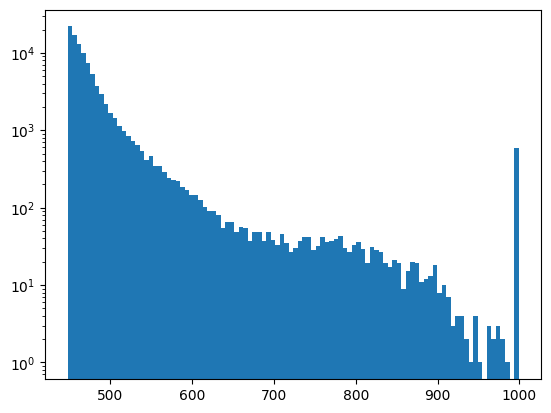

In [110]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

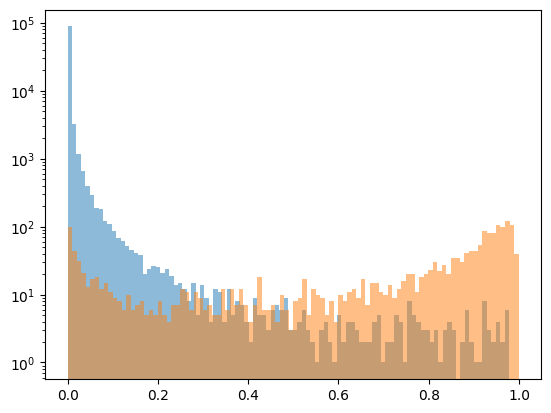

In [111]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

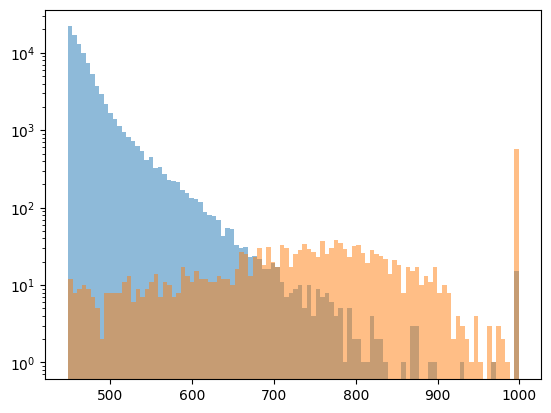

In [112]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [113]:
print("duration: ", datetime.now() - start_time)

duration:  0:01:19.553737


In [114]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/UCSD/2024 Spring Fraud/Classes'